In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import shutil
from Cyclist_env_RDA_2nano import cyclist_env
from time import time
from scipy.fft import fft, ifft
from scipy.linalg import dft

import torch
import pandas as pd
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

In [5]:
def Radar_setting():
    ###### symbol time & carrier frequency ######
    T_symbol = 5.575 * 1e-6              # symbol duration, with CP time
    T_OFDM = 5.2125 * 1e-6
    f_carrier = 28 * 1e+9
    Tc = 2.545*1e-9                      # sampling time

    ###### tx/rx ######
    N_ant = 16                       # the number of antennas
    # BW = 1.966080e+9                      # chirp bandwidth
    BW = 400*1e+6                    # chirp bandwidth
    BW_sub = BW/N_ant
    N_sample = int(np.floor(T_symbol/Tc))           # the number of samples of single chirp
    rx_sample = 813 + N_sample

    ###### Radar setting ######

    mu = BW_sub/T_symbol * 0.98
    l_speed = 299792458

    lam = l_speed/f_carrier
    env = cyclist_env(f_carrier, N_ant, BW, BW_sub, N_sample, rx_sample, Tc, mu, l_speed)
    return T_symbol,f_carrier,Tc,N_ant,BW,BW_sub,N_sample,rx_sample, mu, l_speed, lam, env

In [ ]:
def Sim_Setting():
    # シミュレーション設定
    p_bs = np.array([250, -18, 50])                         #基地局の位置

    # 各車両の数
    num_cy = 1
    num_ve = 1
    num_rp = 0
    # シミュレーション範囲の設定
    start_cy_idx = 150
    start_ve_idx = 150
    #start_cy_idx = 75
    #start_ve_idx = 50

    end_cy_idx = 150
    end_ve_idx = 150
    #end_cy_idx = 135
    #end_ve_idx = 150

    cy_interval = 3
    ve_interval = 5

    cy_v_value = 6
    ve_v_value = 10
    return p_bs, num_cy, num_ve, num_rp, start_cy_idx, start_ve_idx, end_cy_idx, end_ve_idx, cy_v_value, ve_v_value, cy_interval, ve_interval

In [7]:
def syntax_check(num, idx, y_value, velocity_value, x_pos):
    idx_list = np.zeros(num, dtype=np.int32)
    position, velocity = np.zeros((num, 3)), np.zeros((num, 3))
    i=0
    s = set()
    while i < num:
        # 初期値における距離間隔を保証するための処理
        if idx+10 in s or idx-10 in s or idx in s: continue
        for j in range(-20,20): s.add(idx+j)
        
        idx_list[i] = idx
        position[i] = np.array([x_pos[idx], y_value, 1])
        # v_cy[i] = np.array([np.random.rand(1)[0]*5.56, 0, 0])
        velocity[i] = np.array([velocity_value, 0, 0])
        
        i+=1
    return idx_list, position, velocity

In [8]:
def get_snapshot_data(cy_idx_target, ve_idx_target,x_pos, p_bs, tx, cy_v_value, ve_v_value, num_cy, num_ve, num_rp, sym_duration, N_trans,Tc, env):
    # Cyclistについて
    cy_idx = np.zeros(num_cy, dtype=np.int32)
    p_cy, v_cy = np.zeros((num_cy, 3)), np.zeros((num_cy, 3))
    # 範囲外アクセスを防ぐための処理
    cy_idx, p_cy, v_cy = syntax_check(num_cy, cy_idx_target, 15, cy_v_value, x_pos)
    n_cy = len(p_cy)
    
    # Vehicleについて
    ve_idx = np.zeros(num_ve, dtype=np.int32)
    p_ve, v_ve = np.zeros((num_ve, 3)), np.zeros((num_ve, 3))
    # 範囲外アクセスを防ぐための処理
    ve_idx, p_ve, v_ve = syntax_check(num_ve, ve_idx_target, 7.5, ve_v_value, x_pos)
    n_ve = len(p_ve)

    # ramppostについて
    p_rp, v_rp = np.zeros((num_rp, 3)), np.zeros((num_rp, 3))
    n_rp = len(p_rp)
    
    # csvファイルの読み込み
    cy_idx += 1
    ve_idx += 1

    P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp = [], [], [], [], [], [], [], [], []
    # 3番目のデータから読み込み開始（最初の数個はノイズのみのため）
    for i in range(len(cy_idx)):
        df = pd.read_csv("./ped/2.545nano/far/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(cy_idx[i]))
        tstemp_rx_cy.append(np.ceil((df["Time (s)"]/Tc).values[3:]))                            #サンプル時間で割ることでサンプルインデックスに変換
        P_rx_cy.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_cy.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    for i in range(len(ve_idx)):
        df = pd.read_csv("./vehicle/2.545nano/far/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(ve_idx[i]))
        tstemp_rx_ve.append(np.ceil((df["Time (s)"]/Tc).values[3:]))
        P_rx_ve.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_ve.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    #for i in range(1,4):
    #    df = pd.read_csv("./Ramposts/"+str(i)+"/complex-impulse-response-Run0001-Sensor_0_Tx_0_to_Rx_0.csv")
    #    tstemp_rx_rp.append(np.ceil((df["Time (s)"]/Tc).values[5:]))
    #    P_rx_rp.append(df["| Total Complex Impulse Response total | (W)"].values[5:])
    #    phase_rp.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[5:])
    phys_quantities = env.phys_quantities(p_bs, p_cy, v_cy, n_cy, p_ve, v_ve, n_ve, p_rp, v_rp, n_rp)
    print(phys_quantities["relative_velocity"]["cyclists"])
    real_cy_coordinates = []
    real_vel_coordinates = []
    for i in range(len(p_cy)):
        real_cy_coordinates.append(np.array([p_cy[i][0], p_cy[i][1]]))
    for i in range(len(p_ve)):
        real_vel_coordinates.append(np.array([p_ve[i][0], p_ve[i][1]]))
        
    ######### We need some functions here. it is like this. read the csv. this outputs the time stemp and corresponding rx value.
    # P_rx_cy_dB = -114
    #P_rx_cy_dB = -111
    #P_rx_ve_dB = -114
    #P_rx_cy_dB = 0
    #P_rx_ve_dB = 0
    
    P_N_dB = -87.98
    
    Y = env.rx_multiple(tx, P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp, P_N_dB, sym_duration, N_trans)
    
    return Y, phys_quantities, real_cy_coordinates, real_vel_coordinates

#x_pos = list(np.arange(-450, -149)/10)
#p_bs = np.array([250, -18, 50])
#Y, phys_quantities = get_snapshot_data(100,0,x_pos,p_bs)

In [9]:
def derectory_deletor(directory_path):
    try:
        # ディレクトリ内のすべてのエントリ（ファイルとフォルダ）を取得
        for entry in os.listdir(directory_path):
            full_path = os.path.join(directory_path, entry)

            # ファイルかどうかをチェック
            if os.path.isfile(full_path):
                # ファイルを削除
                os.remove(full_path)
            
            # サブディレクトリの場合はスキップ
            elif os.path.isdir(full_path):
                print(f"⏭️ サブディレクトリはスキップしました: {full_path}")
                # サブディレクトリ内のファイルも削除したい場合は、
                # ここで再帰的にこの関数を呼び出すなどの処理が必要です
                # (例: delete_all_files_in_directory(full_path))
    except FileNotFoundError:
        print(f"エラー: ディレクトリが見つかりません - {directory_path}")
    except Exception as e:
        print(f"ファイル削除中にエラーが発生しました: {e}")
    return

In [10]:
def MUSIC_method_improved(Y, N_ant, num_signals):
    '''
    修正前
    Y_music = np.mean(Y, axis=0)
    R_yy = Y_music@np.conjugate(np.transpose(Y_music))
    '''
    # 修正後: 
    # チャープ軸(0)とサンプル軸(2)の両方を「スナップショット」として扱います。
    # (N_trans, N_ant, N_sample) -> (N_ant, N_trans * N_sample) に変形
    # これにより、N_trans(チャープ数)が増えるほど、スナップショット数が増え、
    # 共分散行列 R_yy の推定精度が向上します。
    
    N_trans, N_ant_data, N_sample = Y.shape
    # データを (アンテナ数 x 全サンプル数) の2次元行列に変形
    Y_music = Y.transpose(1, 0, 2).reshape(N_ant_data, -1)
    
    # 共分散行列の計算
    # (行列サイズは アンテナ数 x アンテナ数 のまま変わらないので計算負荷は軽微です)
    R_yy = (Y_music @ np.conjugate(Y_music.T)) / Y_music.shape[1]
    
    # 1.固有値分解
    eig_val, eig_vec = np.linalg.eig(R_yy)

    # 2.固有値をソートして雑音部分空間を取得
    idx = np.abs(eig_val).argsort()[::-1]
    # インデックスによって固有値と固有ベクトルの対応関係を維持しつつソート
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:, idx]
    # 雑音部分空間Uを取得

    # num_signalsを固有値から推定?
    
    # デバッグ用
    num_signals = 5
    
    U = eig_vec[:, num_signals:]

    # 3.雑音部分空間とvalごとのステアリングベクトルの内積を計算
    resp = []
    argm = (np.arange(1800)-900)/100
    for val in argm:
        # ステアリングベクトルの計算
        stv = stevec(N_ant, val*np.pi/180)
        # 雑音部分空間との内積
        p = stv.T@U
        # L2ノルムの二乗を計算(pp^H)
        pp = p*np.conjugate(np.transpose(p))
        # A1は行列を1次元配列に変換するメソッド
        # respに逆数を追加
        # 分子は角度推定の上では不要なので省略している
        resp.append(1/(np.abs(pp)**2).A1)

    # 4.ピーク検出
    M = np.max(resp)
    
    # デバッグ用
    MUSIC_method_Debug(eig_val, N_ant, num_signals, resp, argm, M)
    
    est_ang = []
    # 三点比較によるピーク検出
    a, b = resp[0][0], resp[1][0]
    for i in range(1,len(argm)-1):
        c = resp[i+1][0]
        #if a < b and b > c and b > 0.2 * M:
        if a < b and b > c and b > 0.05 * M:
            est_ang.append(argm[i])
        a, b = b, c
    return est_ang

In [11]:
def MUSIC_method_Debug(eig_val, N_ant, num_signals, resp, argm, M):
    """
    MUSIC法の状態を診断するためのデバッグ関数
    """
    print("\n" + "="*30)
    print("【MUSIC法 デバッグ情報】")
    
    # --- 1. 数値情報の出力 ---
    # 固有値の絶対値（大きい順）
    eig_abs = np.abs(eig_val)
    print(f"1. 固有値 (大きい順):\n{eig_abs}")
    
    # 推定された信号数と閾値情報
    print(f"2. 設定信号数 (K): {num_signals}")
    print(f"3. スペクトル最大値 (M): {M:.2e}")
    print(f"4. 現在の閾値 (20%): {0.2 * M:.2e}")

    # --- 2. グラフ描画 (重要) ---
    try:
        """
        # プロットエリアを2つ作成 (左: 固有値分布, 右: MUSICスペクトル)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        
        # === 左のグラフ: 固有値分布 (Scree Plot) ===
        # これを見ることで、信号がノイズから分離できているか確認できます
        ax1.plot(range(1, len(eig_abs) + 1), eig_abs, 'bo-', markersize=8)
        ax1.set_title('Eigenvalue Distribution (Scree Plot)')
        ax1.set_xlabel('Index')
        ax1.set_ylabel('Eigenvalue (log scale)')
        ax1.set_yscale('log') # 固有値は桁が違うことが多いので対数がおすすめ
        ax1.grid(True, which="both", ls="-", alpha=0.5)
        
        # 信号部分とノイズ部分の境界に線を引く
        ax1.axvline(x=num_signals + 0.5, color='r', linestyle='--', label=f'Separation (K={num_signals})')
        ax1.legend()
        
        # === 右のグラフ: MUSICスペクトル ===
        # どこにピークがあり、閾値でどう切られているか確認します
        resp_array = np.array(resp).flatten() # 形状を1次元に統一
        
        ax2.plot(argm, resp_array, label='MUSIC Spectrum')
        ax2.set_title(f'MUSIC Spectrum (N_ant={N_ant}, K={num_signals})')
        ax2.set_xlabel('Angle [deg]')
        ax2.set_ylabel('Spectrum Power')
        ax2.set_yscale('log') # スペクトルも対数で見ると弱いピークが見つけやすい
        ax2.grid(True, which="both", ls="-", alpha=0.5)
        
        # 閾値の線を引く (赤の点線)
        threshold_val = 0.2 * M
        ax2.axhline(y=threshold_val, color='r', linestyle='--', label='Threshold (20%)')
        
        # もし閾値を5%に下げたらどう見えるかも参考として表示 (緑の点線)
        ax2.axhline(y=0.05 * M, color='g', linestyle=':', label='Threshold (5%)')
        
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        print("-> 診断用グラフを描画しました")
        """
        
        # --- ピークのグラフだけ表示 ---
        fig, ax = plt.subplots(figsize=(8, 5))
        resp_array = np.array(resp).flatten() # 形状を1次元に統一
        
        ax.plot(argm, resp_array, label='MUSIC Spectrum')
        ax.set_title(f'MUSIC Spectrum (N_ant={N_ant}, K={num_signals})')
        ax.set_xlabel('Angle [deg]')
        ax.set_ylabel('Spectrum Power')
        ax.set_yscale('log') # スペクトルも対数で見ると弱いピークが見つけやすい
        ax.grid(True, which="both", ls="-", alpha=0.5)
        
        # 閾値の線を引く (赤の点線)
        threshold_val = 0.2 * M
        ax.axhline(y=threshold_val, color='r', linestyle='--', label='Threshold (20%)')
        
        # もし閾値を5%に下げたらどう見えるかも参考として表示 (緑の点線)
        ax.axhline(y=0.05 * M, color='g', linestyle=':', label='Threshold (5%)')
        
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        print("-> 診断用グラフを描画しました")
        
    except Exception as e:
        print(f"-> グラフ描画中にエラーが発生しました: {e}")
        
    print("="*30 + "\n")

In [12]:
def FFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang, sym_duration, lam, Tc, env):
    # ドップラー処理
    Dopp_dft = dft(N_trans)/np.sqrt(N_trans)
    Y_dft = np.zeros((N_trans, N_ant, rx_sample), dtype=np.complex128)
    for i in range(N_ant):
        Y_dft[:,i,:] = Dopp_dft@Y[:,i,:]

    final_objects_all = []
    rd_maps = []

    P_range = np.arange(190)+620

    # FFTによる位置推定処理
    tx_arr = np.array(tx) 
    n_fft = 2**(int(rx_sample + N_sample).bit_length())
    
    # 窓関数を掛けずにFFTする
    TX_F_all = fft(tx_arr, n=n_fft, axis=1) 
    Y_F_all = fft(Y_dft, n=n_fft, axis=2)

    for i in range(len(est_ang)):
        current_angle = est_ang[i]
        ang_rad = current_angle * np.pi / 180
        
        # ステアリングベクトル (N_ant, 1)
        s_vec = np.array(stevec(N_ant, ang_rad))
        
        # --- 周波数領域でのビームフォーミング ---
        
        # 受信信号の合成: Y_combined = sum(Y * s)
        # s_vec を (1, N_ant, 1) に変形して放送
        # Y_F_all: (N_trans, N_ant, n_fft)
        # 重み付け和をとってアンテナ次元を潰す -> (N_trans, n_fft)
        # 修正前
        w_vec = np.conjugate(s_vec).reshape(1, N_ant, 1)
        Y_F_combined = np.sum(Y_F_all * w_vec, axis=1)
        # 修正後
        w_vec = s_vec.reshape(1, N_ant, 1) 
        Y_F_combined = np.sum(Y_F_all * w_vec, axis=1)

        # 送信信号(レプリカ)の合成: X_combined = sum(X * s*)
        # 元の数式 g = s* s^H X より、Xにかかる重みは s^H (つまり sの共役)
        # TX_F_all: (N_ant, n_fft)
        s_vec_conj_reshape = np.conjugate(s_vec).reshape(N_ant, 1)
        TX_F_combined = np.sum(TX_F_all * s_vec_conj_reshape, axis=0) # -> (n_fft,)

        # --- 相関演算 (Correlation) ---
        # Correlation = IFFT( FFT(Y) * conj(FFT(X)) )
        # Broadcasting: (N_trans, n_fft) * (n_fft,)
        CORR_f = Y_F_combined * np.conjugate(TX_F_combined)
        
        # 時間領域に戻す
        corr_time = ifft(CORR_f, axis=1)

        # --- 必要な範囲を切り出し ---
        rdresp_single = corr_time[:, P_range]

        # --- 結果保存 ---
        rd_maps.append(rdresp_single.copy())
        rd_maps.append(i)

        # 1. CFAR実行
        # radar_inの作成 (Batch, Channel, Height, Width)
        radar_in = torch.tensor(np.abs(rdresp_single)).unsqueeze(0).unsqueeze(0)
        detections_bool = ca_cfar_improved(radar_in, convert_from_db=False)
        
        # 2. dBマップの準備 (Thresholder用)
        radar_db = 20 * torch.log10(radar_in[0,0])

        # 3. 閾値判定 (速度方向も見てフィルタリング)
        # detections_bool[0,0] を渡すことで2次元マップとして処理
        # tar_thres は必要に応じて調整 (-30 や -25 など)
        raw_targets = thresholder_improved(radar_db, detections_bool[0,0], tar_thres=-27.5)

        # 4. 重複除去 (Cleansing)
        clean_targets = cleansing_improved(raw_targets)

        # 検出候補リストからサイドローブを除去
        current_angle_candidates = []

        if len(clean_targets) > 0:
            for tgt in clean_targets:
                d_idx, r_idx, power = tgt
                
                # 物理量への変換
                r_est, v_est, x_est, y_est = convert_to_physical(
                    d_idx, r_idx, N_trans, sym_duration, lam, current_angle, idx_to_xy, Tc, env
                )
                
                # 候補リストに追加
                current_angle_candidates.append([r_est, current_angle, x_est, y_est, v_est, power])
        else:
            # ターゲットが見つからなかった場合の処理（必要ならログ出力）
            pass

        cleaned_objects_in_this_angle = remove_ghosts_across_angles(current_angle_candidates)

        # 結果の表示と保存
        if len(cleaned_objects_in_this_angle) > 0:
            print(f"角度 {current_angle:.2f} 度 のマップからの検出 (Cleaning後):")
            for obj in cleaned_objects_in_this_angle:
                r_est, angle, x_est, y_est, v_est, power = obj
                print(f"  -> Power: {power:.1f}dB, Range: {r_est:.2f}m, Vel: {v_est:.2f}m/s")
                
                # 全体のリストに追加
                final_objects_all.append(obj)
        else:
            # print(f"角度 {current_angle:.2f} 度: ターゲットなし")
            pass
        
    return final_objects_all, rd_maps

In [13]:
def ca_cfar_improved(x_db, n_train=(1,7), n_guard=(1,5), pfa=1e-6, convert_from_db=False):
    """
    2次元 CA-CFAR (Cell Averaging CFAR)
    x_db: (B, 1, H, W) 入力マップ (通常はdB)
    戻り値: (B, 1, H, W) のBool型テンソル (Trueが検出位置)
    """
    # 修正
    n_guard = (1,10)
    pfa = 1e-4

    if convert_from_db:
        x = 10 ** (x_db / 10.0)
    else:
        x = x_db

    B, C, H, W = x.shape
    th, tw = n_train
    gh, gw = n_guard

    # カーネル作成 (ガードセルを0、参照セルを1にする)
    kh = 2 * (th + gh) + 1
    kw = 2 * (tw + gw) + 1
    kernel = torch.ones((1, 1, kh, kw), device=x.device, dtype=x.dtype)

    #kernel[:, :, th-gh:th+gh+1, tw-gw:tw+gw+1] = 0
    # 修正案
    kernel[:, :, th : th + 2*gh + 1, tw : tw + 2*gw + 1] = 0

    N_train = kernel.sum().item()
    
    # 閾値係数 alpha の計算
    alpha = N_train * (pfa ** (-1.0 / N_train) - 1.0)

    # 修正案
    # ドップラー方向(H)は「circular」(循環)、レンジ方向(W)は「replicate」(端の値を複製)したい場合
    # PyTorchのF.padは一度に1つのモードしか指定できないため、2段階で適用します

    # 1. レンジ方向（左右）のパディング（非循環）
    pad_w = kw // 2
    x_pad_w = F.pad(x, (pad_w, pad_w, 0, 0), mode="replicate") # または "constant"

    # 2. ドップラー方向（上下）のパディング（循環：上端と下端をつなげる）
    pad_h = kh // 2
    x_pad = F.pad(x_pad_w, (0, 0, pad_h, pad_h), mode="circular")
    
    train_sum = F.conv2d(x_pad, kernel)
    noise_est = train_sum / N_train

    threshold_map = alpha * noise_est
    detections = x > threshold_map
    
    return detections

In [14]:
def thresholder_improved(radar_db, detections_bool, tar_thres=-25):
    """
    radar_db:        (H, W) の2次元テンソル (dB単位のRDマップ)
    detections_bool: (H, W) の2次元Boolテンソル (CFARの結果)
    tar_thres:       ターゲットとみなす最小強度 (dB)
    
    戻り値: 検出リスト [[doppler_idx, range_idx, power], ...]
    """
    # CFARでTrueになったインデックスをすべて取得 (Doppler, Range)
    # as_tuple=False で [[d, r], [d, r]...] のリスト形式で取得
    coords = torch.nonzero(detections_bool, as_tuple=False).tolist()
    
    valid_targets = []
    H, W = radar_db.shape
    print(len(coords))
    for coord in coords:
        d_idx, r_idx = coord[0], coord[1]
        
        # 注目領域 (ROI) を設定
        # 以前は radar[:5, ...] と固定していたが、
        # ここでは検出された d_idx の周辺を見るように変更
        d_min = max(0, d_idx - 1)
        d_max = min(H, d_idx + 2) # Pythonのスライスは末尾を含まないため+2
        r_min = max(0, r_idx - 5)
        r_max = min(W, r_idx + 6)
        
        # ROI内の最大パワーを取得
        # 最大値を全検出点に割り当ててしまっている問題を改善
        # そのピンポイントのパワーを取得する
        peak_power = radar_db[d_idx, r_idx].item()
        
        # 閾値チェック
        if peak_power > tar_thres:
            valid_targets.append([d_idx, r_idx, peak_power])
            
    return valid_targets

In [15]:
def cleansing_improved(targets, dist_tol=0, dop_tol=0):
    """
    targets: [[dop_idx, rng_idx, power], ...] のリスト
    dist_tol: 同一物体とみなす距離(レンジ)インデックスの差
    dop_tol:  同一物体とみなす速度(ドップラー)インデックスの差
    
    戻り値: 重複除去後のターゲットリスト
    """
    if not targets:
        return []
        
    # パワーが強い順にソート (強い信号を優先して残すため)
    # x[2] が power
    targets_sorted = sorted(targets, key=lambda x: x[2], reverse=True)
    
    final_targets = []
    
    while targets_sorted:
        # 最も強いターゲットを取り出す
        best = targets_sorted.pop(0)
        final_targets.append(best)
        
        # このターゲットに「近すぎる」ものをリストから除去する
        # 距離とドップラーの両方で近いものを重複とみなす
        candidates = []
        for other in targets_sorted:
            d_diff = abs(best[0] - other[0])
            r_diff = abs(best[1] - other[1])
            
            # 許容範囲外(＝別の物体)なら残す
            if not (d_diff <= dop_tol and r_diff <= dist_tol):
                candidates.append(other)
        
        targets_sorted = candidates
        
    return final_targets

In [26]:
def remove_ghosts_across_angles(all_detections, range_tol=2.0, ang_tol=1.0, vel_tol=0.5):
    """
    異なる角度で検出された同一物体（サイドローブ）を統合する関数
    all_detections: [[range, vel, angle, x, y, power], ...] のリスト
    range_tol: 同一物体とみなす距離差 [m]
    vel_tol:   同一物体とみなす速度差 [m/s]
    """
    if not all_detections:
        return []

    # 1. パワーが強い順に並べ替える (一番後ろの要素がpowerと仮定)
    # x[5] が power です
    sorted_dets = sorted(all_detections, key=lambda x: x[5], reverse=True)
    
    final_unique_objects = []
    
    while sorted_dets:
        # 最も強い検出を取り出す（これが「本物」の可能性が高い）
        best = sorted_dets.pop(0)
        final_unique_objects.append(best)
        
        # 残りのリストから、「距離と角度がほぼ同じ」ものを全て削除する
        # （これらはサイドローブ＝ゴーストとみなす）
        remaining = []
        for other in sorted_dets:
            r_diff = abs(best[0] - other[0])
            a_diff = abs(best[1] - other[1])
            v_diff = abs(best[4] - other[4])
            
            # 距離と角度が近ければ、それは同じ物体のサイドローブなのでリストに残さない（削除）
            if r_diff < range_tol and a_diff < ang_tol:
                continue 
            # 距離と速度が近ければ、それは同じ物体のサイドローブなのでリストに残さない（削除）
            if r_diff < range_tol and v_diff < vel_tol:
                continue
            remaining.append(other)
        
        sorted_dets = remaining

    return final_unique_objects

In [17]:
def convert_to_physical(d_idx, r_idx, N_trans, sym_duration, lam, current_angle, idx_to_xy_func, Tc, env):
    """
    インデックスを物理的な距離(m)と速度(m/s)に変換
    """
    # 速度計算
    vel_res = lam / (2.0 * sym_duration * N_trans)
    if d_idx < N_trans / 2:
        velocity = d_idx * vel_res
    else:
        velocity = (d_idx - N_trans) * vel_res
        
    # 距離・座標計算 (既存の関数を利用)
    x, y, r = idx_to_xy_func(r_idx, current_angle, Tc, env)
    
    return r, velocity, x, y

In [18]:
def stevec(N_ant, angle):
    # 入力された角度に対するステアリングベクトルの計算
    resp = (np.arange(N_ant)-N_ant*0.5+0.5).reshape([-1,1])
    resp = np.exp(1j*resp*np.pi*np.sin(angle))
    return np.matrix(resp)

In [19]:
def idx_to_xy(range_idx, angle_deg, Tc, env):
    """
    range_idx: cy_idxs_pred の値 (例: 496)
    angle_deg: MUSIC法で推定した角度 [度] (例: est_ang[0])
    """
    p_bs = np.array([250, -18, 50])
    refangle = np.arctan(33/265)/2
    offset = 620
    # (1) 距離の計算 [m]
    # サンプル番号 = インデックス + オフセット
    sample_idx = range_idx + offset
    # 往復時間 = サンプル番号 * Tc
    # 距離 = 往復時間 * c / 2
    R = (sample_idx * Tc * env.c) / 2

    # 三次元距離を二次元距離に変換
    height_diff = p_bs[2] - 1
    if R > height_diff:
        R_horizontal = np.sqrt(R**2 - height_diff**2)
    else:
        R_horizontal = 0

    # (2) 角度の計算 [rad]
    # 推定角度をラジアンに変換し、基準角度(refangle)を足す
    # anglecalの逆演算: cy_ang = arctan(...) - refangle なので
    # arctan(...) = cy_ang + refangle
    theta_world = np.deg2rad(angle_deg) + refangle

    # (3) XY座標の計算 [m]
    # 基地局(p_bs)からの相対位置
    # cy_denum (dx) = R * cos(theta)
    # cy_nu (dy) = R * sin(theta)
    dx = R_horizontal * np.cos(theta_world)
    dy = R_horizontal * np.sin(theta_world)

    # 世界座標（絶対座標）に変換
    # cy_denum = bs[0] - cy[0]  =>  cy[0] = bs[0] - dx
    # cy_nu    = cy[1] - bs[1]  =>  cy[1] = bs[1] + dy
    x = p_bs[0] - dx
    y = p_bs[1] + dy

    return x, y, R

In [20]:
def RD_MAP(rd_maps, frame_id, T_symbol, Tc, save_dir="./rd_maps/"):
    l_speed = 299792458 
    f_carrier = 28 * 1e+9

    lam = l_speed / f_carrier
    
    
    # ディレクトリがなければ作成
    os.makedirs(save_dir, exist_ok=True)
    
    rdresp_list = np.array(rd_maps[::2])
    #idx = np.array(rd_maps[1::2])
    
    # 距離分解能 (m)
    range_res = l_speed * Tc / 2
    print(range_res)
    
    # 横軸 (距離):
    start_sample_idx = 620
    num_range_bins = 190

    r_min = start_sample_idx * range_res
    r_max = (start_sample_idx + num_range_bins) * range_res

    v_range = lam / (2 * T_symbol)  # 最大速度範囲

    v_min_val = -v_range / 2
    v_max_val = v_range / 2
    
    i = 0

    for rd_resp in rdresp_list:
        #output = rd_resp[:100,:] + 1e-10
        #output = rd_resp + 1e-10
        output = np.fft.fftshift(rd_resp, axes=0) + 1e-10
        plt.imshow(20*np.log10(np.abs(output)), aspect='auto', interpolation='nearest',
             extent = [r_min, r_max, v_min_val, v_max_val], origin='lower', vmin=-30, vmax = -10)
        plt.xlabel('Range [m]')
        plt.ylabel('Velocity [m/s]') # 注: DFTのシフトをしていないため、軸の解釈に注意が必要
        plt.colorbar(label='Power [dB]')
        plt.title('Range-Doppler Map')
        plt.grid(False) # 任意
        plt.xlim(r_min,r_max)
        plt.ylim(-30,30)
        # --- 保存処理 ---
        # ファイル名を決定 (例: ./rd_maps/rd_map_12345.png)
        save_path = os.path.join(save_dir, f"rd_map_{frame_id}_for_{i}.png")
        plt.savefig(save_path)
        print(f"Saved: {save_path}")
        
        # --- クローズ処理 ---
        # show() ではなく close() することで、画面表示せずバックグラウンドで処理できます
        # 表示もしたい場合は plt.show() の前に plt.savefig() を置いてください
        plt.close()
        i += 1
    
    # 保存する
    

In [21]:
def main_simulation(i):
    # --- 保存先ディレクトリの設定 ---
    base_dir = "./montecarlo"
    rd_map_dir = os.path.join(base_dir, "rd_maps")
    
    os.makedirs(rd_map_dir, exist_ok=True)
    
    # 実行用設定
    T_symbol,f_carrier,Tc,N_ant,BW,BW_sub,N_sample,rx_sample, mu, l_speed, lam, env = Radar_setting()
    N_chirp = 89
    N_trans = N_chirp
    tx = env.tx()
    p_bs, num_cy, num_ve, num_rp, start_cy_idx, start_ve_idx, end_cy_idx, end_ve_idx, cy_v_value, ve_v_value, cy_interval, ve_interval = Sim_Setting()
    cy_idx, ve_idx = start_cy_idx, start_ve_idx
    measurement_history = []
    frame_count = 0
    
    # 画像フォルダの中身を削除 (必要に応じてコメントアウト)
    # 毎回削除すると、前の回の画像が消えます。
    derectory_deletor(rd_map_dir)
    
    T_sensing = N_chirp * T_symbol + 813 * Tc
    
    real_cy_coordinates_all, real_cy_ranges_all, real_cy_angles_all, real_cy_velocities_all, real_ve_coordinates_all, real_ve_ranges_all, real_ve_angles_all, real_ve_velocities_all = [], [], [], [], [], [], [], []

    while cy_idx <= end_cy_idx and ve_idx <= end_ve_idx:
        x_pos = list(np.arange(-450, -149)/10)
        
        Y, phys_quantities, real_cy_coordinates, real_vel_coordinates = get_snapshot_data(cy_idx,ve_idx,x_pos,p_bs, tx, cy_v_value, ve_v_value, num_cy, num_ve, num_rp, T_symbol, N_trans, Tc, env)
        if num_cy > 0:
            print("Cyclist True Position:", real_cy_coordinates)
            print("Cyclist True Range:", phys_quantities["range"]["cyclists"][0])
            print("Cyclist True Angle:", math.degrees(phys_quantities["angle"]["cyclists"][0]))
            real_cy_coordinates_all.append(real_cy_coordinates)
            real_cy_ranges_all.append(phys_quantities["range"]["cyclists"][0])
            real_cy_angles_all.append(phys_quantities["angle"]["cyclists"][0])
            real_cy_velocities_all.append(phys_quantities["relative_velocity"]["cyclists"][0])
        if num_ve > 0:
            print("Vehicle True Position:", real_vel_coordinates)
            print("Vehicle True Range:", phys_quantities["range"]["vehicles"][0])
            print("Vehicle True Angle:", math.degrees(phys_quantities["angle"]["vehicles"][0]))
            real_ve_coordinates_all.append(real_vel_coordinates)
            real_ve_ranges_all.append(phys_quantities["range"]["vehicles"][0])
            real_ve_angles_all.append(phys_quantities["angle"]["vehicles"][0])
            real_ve_velocities_all.append(phys_quantities["relative_velocity"]["vehicles"][0])
        
        est_ang = MUSIC_method_improved(Y, N_ant, num_cy + num_ve + num_rp)
        
        print(est_ang)

        detected_objects, rd_maps = FFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang, T_symbol, lam, Tc, env)
        
        # 画像保存 (シミュレーション番号 i をファイル名に含めると区別可能です)
        # ただし derectory_deletor が有効だと消えてしまうので注意
        RD_MAP(rd_maps, frame_count, T_symbol, Tc, save_dir=rd_map_dir)
        
        if len(detected_objects) > 0:
            for obj in detected_objects:
                measurement_history.append({
                    "Time": frame_count,
                    "Range": obj[0],
                    "Angle": obj[1],
                    "X": obj[2],
                    "Y": obj[3],
                    "Velocity": obj[4]
                })
        else:
            measurement_history.append({
                "Time": frame_count,
                "Range": np.nan,
                "Angle": np.nan,
                "X": np.nan,
                "Y": np.nan,
                "Velocity": np.nan
            })
        
        cy_idx += cy_interval
        ve_idx += ve_interval
        frame_count += 1
        
    # --- CSV保存 (番号付き) ---
    df_measurements = pd.DataFrame(measurement_history)
    csv_filename = os.path.join(base_dir, f"measurements_{i}.csv") # ここを修正
    df_measurements.to_csv(csv_filename, index=False)

    print("\nData generation complete.")
    print(f"Saved '{csv_filename}'.")

    real_positions = []
    csv_filename_true = os.path.join(base_dir, f"true_information_{i}.csv") # ここを修正
    
    # 【重要修正】 変数名を i から k に変更 (引数 i との衝突回避)
    for k in range(max(len(real_cy_coordinates_all), len(real_ve_coordinates_all))):
        if num_cy > 0:
            real_positions.append({
                "Time": k,
                "target_id":0,
                "X": real_cy_coordinates_all[k][0][0],
                "Y": real_cy_coordinates_all[k][0][1],
                "Range": real_cy_ranges_all[k],
                "Angle": real_cy_angles_all[k],
                "Velocity": real_cy_velocities_all[k],
            })

        if num_ve > 0:
            real_positions.append({
                "Time": k,
                "target_id":1,
                "X": real_ve_coordinates_all[k][0][0],
                "Y": real_ve_coordinates_all[k][0][1],
                "Range": real_ve_ranges_all[k],
                "Angle": real_ve_angles_all[k],
                "Velocity": real_ve_velocities_all[k]
            })
            
    df_real_positions = pd.DataFrame(real_positions)
    df_real_positions.to_csv(csv_filename_true, index=False)
    print(f"Saved true positions to '{csv_filename_true}'.")


--- Simulation Run 1/1 ---
[np.float64(5.870753506443861)]
Cyclist True Position: [array([-30.,  15.])]
Cyclist True Range: 286.1642884777903
Cyclist True Angle: 3.1725069778811106

【MUSIC法 デバッグ情報】
1. 固有値 (大きい順):
[5.30235220e-12 1.60976441e-12 1.60814620e-12 1.60298814e-12
 1.60093041e-12 1.60034548e-12 1.59813719e-12 1.59464172e-12
 1.59305735e-12 1.59005376e-12 1.58639679e-12 1.58447415e-12
 1.58244735e-12 1.58056791e-12 1.57879477e-12 1.57219246e-12]
2. 設定信号数 (K): 5
3. スペクトル最大値 (M): 2.96e+06
4. 現在の閾値 (20%): 5.92e+05


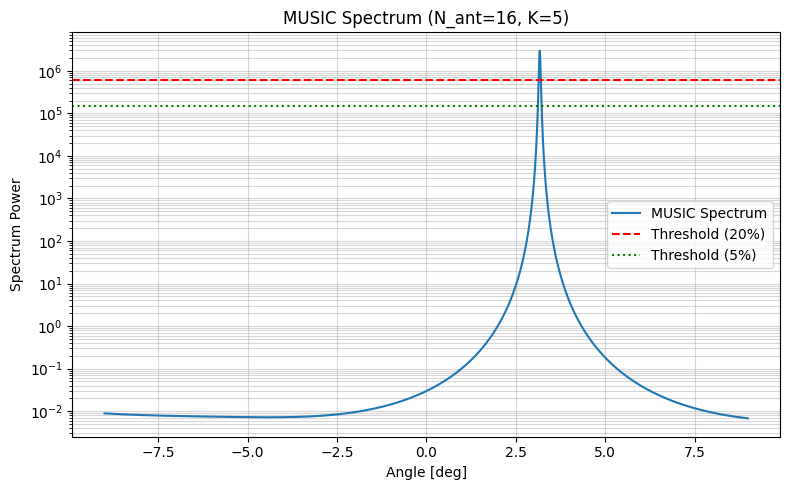

-> 診断用グラフを描画しました

[np.float64(3.17)]
42
角度 3.17 度 のマップからの検出 (Cleaning後):
  -> Power: -19.1dB, Range: 286.50m, Vel: 10.79m/s
0.38148590280500005
Saved: ./montecarlo\rd_maps\rd_map_0_for_0.png

Data generation complete.
Saved './montecarlo\measurements_0.csv'.
Saved true positions to './montecarlo\true_information_0.csv'.


In [29]:
def montecarlo_simulation():
    num_simulations = 1
    for i in range(num_simulations):
        print(f"\n--- Simulation Run {i+1}/{num_simulations} ---")
        main_simulation(i)

montecarlo_simulation()